In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

%matplotlib inline

# Correlated Processes
## Geometric Brownian Motion

We are modeling stock prices as Geometric Brownian Motion, 

$$\frac{dS_k}{S_k} = \mu dt + \sigma \epsilon_k \sqrt{dt},$$

where $k$ is the index for the stock. 
Often times, for simplicity, we simply denote the Wiener processes $\epsilon_{k}\sqrt{dt} = dW_k$, yielding the more compact

$$\frac{dS_k}{S_k} = \mu dt + \sigma dW_k,$$

where $\langle dW_k\rangle = 0, \langle dW_k^2\rangle = dt$ still.

As a warm up, let's find the variance of $\frac{dS_k}{S_k}$:

$$ \left\langle \frac{dS_k}{S_k} \frac{dS_k}{S_k}\right\rangle = \langle (\mu dt + \sigma dW_k)^2\rangle.$$

We multiply out the terms and get 


\begin{align}
\left\langle \frac{dS_k}{S_k} \frac{dS_k}{S_k}\right\rangle &= 
\langle (\mu dt)^2\rangle + \langle 2\mu\sigma \,dt\, dW_k\rangle + \langle \sigma^2 dW_k^2\rangle \\
&= (\mu dt)^2 +2\mu\sigma dt\, \langle  dW_k\rangle + \sigma^2 \langle dW_k^2\rangle\\
&= \sigma^2 dt
\end{align}

since $dt^2\ll dt$ and $\langle dW_k\rangle = 0$.

Our intuition and analysis of past stock prices tell is that they are correlated. 
As a result, it'd be insufficient to describe the stock prices of different stocks as independent random walkers following a Geometric Brownian Motion. 
Instead, we need to find a way to link them together and encode the degree of correlation.

To build intuition, let's start with two stocks, $S_1$ and $S_2$.

\begin{align}
\frac{dS_1}{S_1} &= \mu dt + \sigma dW_1,\\
\frac{dS_2}{S_2} &= \mu dt + \sigma dW_2.
\end{align}

In the next step, we need to assume that the stochastic terms $dW_1, dW_2$ are not independent of each other, which implies

$$\langle dW_1 dW_2\rangle = \rho dt\ne 0.$$

$\rho$ is called the correlation coefficient betwen 1 and 2.

To see if this yields the desired result, what is the covariance of $\frac{dS_1}{S_1}$ and $\frac{dS_2}{S_2}$?

\begin{align}\left\langle \frac{dS_1}{S_1} \frac{dS_2}{S_2}\right\rangle &= \langle(\mu dt +\sigma dW_1)\times (\mu dt + \sigma dW_2)\rangle\\
&= \langle \mu^2 dt^2\rangle + \langle \mu dt\,\sigma dW_1\rangle + \langle \mu dt\, \sigma dW_2\rangle + \langle \sigma^2dW_1 dW_2\rangle\\
&=\rho \sigma^2 dt
\end{align}

which checks out.

At this point, it makes sense to move to matrix notation for two reasons.
Firstly, it simplifies notation when we want to move to more than two stocks.
Secondly, it makes it easier to see how we will have to simulate the process in Python.

We define the covariance matrix, allowing for more generality and $\sigma_1\ne \sigma_2$ for the two stocks,

$$\Sigma = \begin{pmatrix}\sigma_1^2 & \rho \sigma_1\sigma_2 \\ \rho \sigma_1\sigma_2 & \sigma_2^2\end{pmatrix}.$$

Further, even the drift term may be different, meaning we may have $\mu_1\ne\mu_2$.

Then, in the same way that the next step of an individual random walker with drift was given as a normal distribution with mean $\mu$ and variance $\sigma^2$, the next step of our two random walkers will be given by a multivariate normal distribution with the means ${\bf \mu} = (\mu_1, \mu_2)$ and covariance matrix ${\bf \Sigma}$.

We discretize the stochastic differential equation equation and the increment, 

$$\Delta S_k/S_k \sim \mathcal{N}({\bf \mu}, {\bf \Sigma}),$$

and the stock price at time $T = N\Delta t$ can be written as 

$$S_k(T) = S_0 \Pi_{t=1}^N (1+\Delta S_k).$$

#### Problem 1.

Create three plots of a couple of random walkers, with $\rho=-0.4, 0.2, 0.8$, respectively. Use $T=252$, $\Delta t =1$, $\sigma_1=\sigma_2=0.14/\sqrt{252}$ and $\mu_1=0.12/252, \mu_2=0.08/252$. 

With these parameters, you describe the daily stock price of stocks that returns 12% and 8%, respectively, per year with a standard deviation of 14% for one year.

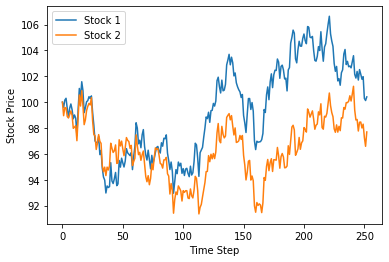

In [24]:
N = 252
rho = 0.9
mu1 = 0.12/N
mu2 = 0.08/N
sigma1 = 0.14 / np.sqrt(N)
sigma2 = 0.14 / np.sqrt(N)

cov = np.array([[sigma1*sigma1,     rho*sigma1*sigma2],
                [rho*sigma1*sigma2, sigma2*sigma2    ]])

mu = np.array([mu1, mu2])

DeltaS = np.random.multivariate_normal(mu, cov, 252)

# Simulate the stock prices for the two
T = 252
S_0 = 100
stock_1 = np.zeros(T+1)
stock_2 = np.zeros(T+1)
stock_1[0] = S_0
stock_2[0] = S_0

# Calculate with loop
for i in range(T):
    stock_1[i+1] = stock_1[i]*(1+DeltaS[i,0])
    stock_2[i+1] = stock_2[i]*(1+DeltaS[i,1])

# Calculate with numpy special functions
#initial_stock_prices = np.array([S_0,S_0])
#stock_prices = np.concatenate(initial_stock_prices, 1+DeltaS)
#print(stock_prices)
#print(np.cumprod(1+DeltaS, axis=0))
    
# Plot the results
fig, ax = plt.subplots(1,1)
ax.plot(stock_1, label='Stock 1')
ax.plot(stock_2, label='Stock 2')
ax.set_xlabel('Time Step')
ax.set_ylabel('Stock Price')
plt.legend()


# Portfolio Optimization

## Markowitz Portfolios


#### Problem 2.

If your Python distribution does not have Pandas installed yet, install it now and load it using

```python
import pandas as pd
```

For better visualization, I recommend installing Seaborn as well and import it as

```python 
import seaborn as sns
```

Load the file "2_Stock_Prices.csv" from Blackboard, using the command 

```python
df = pd.read_csv("./2_Stock_Prices.csv", index_col=0, parse_dates=True)
```

which automatically parses the first column as the date-index and generates a DataFrame object.

These are the adjusted close prices for the 200 largest firms, sorted by their weight in the S&P 500 as of mid-2019. We are going to find out which portfolio is the one that is "optimal" according to the criteria discussed in lecture.

First, we are going to have to do a few preliminary steps:
<li>
 <ul>Clean the data. We want to exclude any stocks for which we don't have the full price history. This can be done with 
 ```python
 df = df.dropna(axis=1)
 ``` 
 </ul>
checking for missing entries along the time axis for each stock.
 <ul>Then we need to transform to log-prices: 
 ```python
 df = df.apply(np.log)
 ```
 </ul>
 <ul>The portfolio optimization procedure works with returns, so we need calculate the first differences of the log-returns (and delete the first empty line for which we can't compute a return):
 ```python
 returns_df = df.diff().dropna(axis=0)
 ```
 </ul>
</li>
Now we're ready to proceed.

The usefulness and beauty of Pandas DataFrames lies in their good visual representation and ease of use because most mathematical / statistical functions are either implemented or can easily be borrowed from numpy (see our  ```np.log ``` example above). 

Calculating the covariance and correlation is no different: ```returns_df.cov()``` and ```returns_df.corr()``` do the trick!

Using 
 ```python
 sns.heatmap(returns_df.corr(), vmin=-1, vmax=1, cmap="PiYG")
 ```
you can create a visual representation of the correlation matrix where the color scale ranges from -1 to +1 and goes from pink through white to green (```"PiYG"```).

In [27]:
import pandas as pd 
import seaborn as sns
df = pd.read_csv("./data/2_Stock_Prices.csv", index_col=0, parse_dates=True)


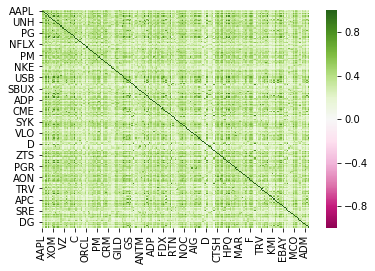

In [29]:
# Clean/transform the data
df = df.dropna(axis=1)
df = df.apply(np.log)
# Get the dataframe with daily returns
returns_df = df.diff().dropna(axis=0)
# Plot the correlations
sns.heatmap(returns_df.corr(), vmin=-1, vmax=1, cmap="PiYG")

Now, Markowitz Optimization is exactly that, an optimization procedure. 
Therefore, we need to invoke an appropriate function to get the job done:
```python 
from scipy.optimize import minimize
```

To reduce the computational load, pick 5 stocks of your liking, which is done in the following way:
```python 
my_stocks_df = returns_df.loc[:, ["Column Name of Stock 1", ..., "Column Name of Stock 5"]]
```
Then find the covariance matrix, as above. Use the following code to determine the portfolio.
You will need to make some assumptions about the expected return of each of the stocks, which you need to pass as the variable ```means = np.array([mu1, mu2, mu3, mu4, mu5])```, plugging in numbers for your forecast.

In [31]:
from scipy.optimize import minimize


# Compute the return of the portfolio, the volatility, and the Sharpe Ratio
def get_ret_vol_sr(weights, means, cov, rf=0.05):
    weights = np.array(weights)
    # The means you enter are daily expected returns, so annualize them.
    ret = np.sum(means*weights*252)
    # The volatility is w*Sigma*w
    vol = np.sqrt(np.dot(weights.T, np.dot(cov, weights)))

    sr = (ret-rf)/vol

    return np.array([ret, vol, sr])

def find_weights(means, cov, rf=0.05):
    
    # Compute the return of the portfolio, the volatility, and the Sharpe Ratio
    def get_ret_vol_sr(weights):
        weights = np.array(weights)
        # The means you enter are daily expected returns, so annualize them.
        ret = np.sum(means*weights*252)
        # The volatility is w*Sigma*w
        vol = np.sqrt(np.dot(weights.T, np.dot(cov, weights)))

        sr = (ret-rf)/vol

        return np.array([ret, vol, sr])    
          
    # We want to maximize the Sharpe Ratio, ergo minimize the negative Sharpe Ratio.
    def neg_sharpe(weights):
        return -get_ret_vol_sr(weights)[2]

    # Function for the constraints: We want to invest all of our money, nothing more, nothing less.
    def check_sum(weights):
        # Return 0 if sum of the weights is 1
        return np.sum(weights)-1
    
    # Set the constraint: Weights need to sum to 1.
    cons = ({"type":"eq", "fun":check_sum})
    # Each stock should have some weight between 0 and 100% in our portfolio.
    bounds = tuple([(0,1) for _ in range(len(means))])
    
    # Our initial guess is equally spreading the money.
    init_guess = [1./len(means) for _ in range(len(means))]
    
    # Optimize!
    opt_results = minimize(neg_sharpe, init_guess, method="SLSQP", bounds=bounds, constraints=cons)
    
    return opt_results

In [52]:
# Choose 5 stocks
my_df = returns_df.loc[:, ['D', 'JPM', 'UNH', 'PG', 'PM']]
means = np.array([0.03/252, 0.03/252, 0.03/252, 0.03/252, 0.03/252])*2
cov = my_df.cov()

# Run the optimizer
opt = find_weights(means, cov)

# If you output opt, you get a bunch of info, and in "x", the weights are stored.
weights = opt["x"]
print(weights)

[0.25790525 0.07968864 0.1866545  0.35203291 0.12371869]


#### Problem 3.

We are now going to combine Problem 1 and Problem 2 for new insight.

Consider the following input for daily mean returns and daily covariance for the optimizer and find the weights.

/Users/alpakpinar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  


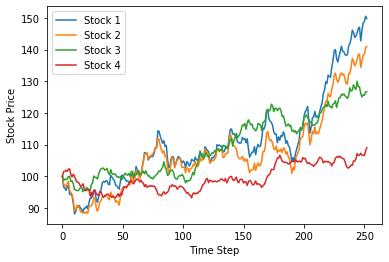

In [81]:
means = [5e-4, 5e-4, 5e-4, 5e-4]

cov = np.array([[0.0625, 0.05625, 0.01875, -0.00625],
                [0.036, 0.04, 0.012, 0.008], 
                [0.00675, 0.00675, 0.0225, 0.009],
                [-0.001, 0.002, 0.004, 0.01]]) / 252


# Find the optimal weights before simulation
opt_before = find_weights(means, cov)
weights_before = opt_before['x']

# Run simulation of four stocks
DeltaS = np.random.multivariate_normal(means, cov, 252)

# Simulate the stock prices for the two
T = 252
S_0 = 100
# Store tbe prices of 4 stocks
stocks = []
for i in range(4):
    stocks.append(np.zeros(T+1))
    stocks[i][0] = S_0
    
# Calculate with loop
for time_step in range(T):
    for stock_idx, stock in enumerate(stocks):
        stock[time_step+1] = stock[time_step]*(1+DeltaS[time_step, stock_idx])

fig, ax = plt.subplots(1,1)
for idx, stock in enumerate(stocks):
    ax.plot(stock, label=f'Stock {idx+1}')
    ax.set_xlabel('Time Step')
    ax.set_ylabel('Stock Price')

plt.legend()

# Get log returns
log_returns = []
for stock in stocks:
    log_returns.append(np.diff(np.log(stock)))

# Calculate covariance matrix out of log returns
sigmas = []
for idx, stock in enumerate(stocks):
    sigmas.append(
            np.std(log_returns[idx])
    )

cov_after = np.zeros((4,4))
# Continue from here...


Now, in reality, we do not know the proper covariance matrix, but like above we need to estimate it from the data.
Let's do a little experiment. Similar to Problem 1, generate 252 time steps of random walkers for for hypothetical stocks described  with the daily returns and the daily covariance matrix above. 

Use the output to estimate the covariance matrix. Then run the optimization procedure again. Compare the weights -- they should be identical, but are they?